In [7]:
import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_sample_images
import matplotlib.pyplot as plt

Dataset basic operations

In [2]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [3]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [4]:
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In [5]:
dataset = dataset.map(lambda x: x * 2)
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


In [6]:
dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)


In [7]:
for item in dataset.take(2):
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)


Shuffle

In [8]:
dataset = dataset.repeat(3)
dataset = dataset.shuffle(buffer_size=4, seed=42)
for item in dataset:
    print(item)

tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)


In [9]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_mean, X_std = scaler.mean_, scaler.scale_

In [11]:
def save_to_csv(data, dataset_name, prefix, header, chunks_num):
    main_dir = Path() / 'datasets' / dataset_name
    main_dir.mkdir(parents=True, exist_ok=True)
    filename = "{}_{}_{:02d}.csv" # dataset name, prefix, file_num

    all_files = []
    for idx, chunk in enumerate(np.array_split(data, chunks_num)):
        file_path = main_dir / filename.format(dataset_name, prefix, idx)
        with open(file_path, 'w') as file:
            if header is not None:
                file.write(header + '\n')
            for row in chunk:
                file.write(','.join([repr(col) for col in row]) + '\n')
        all_files.append(str(file_path))
    
    return all_files

In [12]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)
dataset_name = 'housing'

train_filepaths = save_to_csv(train_data, dataset_name, "train", header, 20)
valid_filepaths = save_to_csv(valid_data, dataset_name, "valid", header, 10)
test_filepaths = save_to_csv(test_data, dataset_name, "test", header, 10)

Reading from multiple files

In [13]:
# dataset with file paths
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [14]:
n_readers = 5
dataset = filepath_dataset.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1), cycle_length=n_readers)

In [15]:
for line in dataset.take(5):
    print(line)

tf.Tensor(b'4.2083,44.0,5.323204419889502,0.9171270718232044,846.0,2.3370165745856353,37.47,-122.2,2.782', shape=(), dtype=string)
tf.Tensor(b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215', shape=(), dtype=string)
tf.Tensor(b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625', shape=(), dtype=string)
tf.Tensor(b'3.3456,37.0,4.514084507042254,0.9084507042253521,458.0,3.2253521126760565,36.67,-121.7,2.526', shape=(), dtype=string)
tf.Tensor(b'3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442', shape=(), dtype=string)


Data preprocessing

In [16]:
n_inputs = 8

def parse_csv_line(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y

In [17]:
processed_dataset = dataset.map(preprocess)
for line in processed_dataset.take(5):
    print(line)

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([ 0.36618188, -0.998705  ,  0.00781878, -0.00675364, -0.06140145,
        0.0072037 , -0.94465536,  0.9367464 ], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.418], dtype=float32)>)
(<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-0.7398411 , -0.36583957, -0.78467995,  0.07414506,  0.75447065,
        0.40770054, -0.68699217,  0.60190356], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.], dtype=float32)>)
(<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([ 0.19852655,  1.2954322 , -0.13117608, -0.31340504, -0.8508079 ,
       -0.04867317,  0.85898864, -1.3022108 ], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.67], dtype=float32)>)
(<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-0.8936168 ,  0.9789995 , -0.6810549 , -0.07264194, -0.5669866 ,
       -0.39212456, -1.3522334 ,  1.2316071 ], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, nu

In [18]:
# loading and preprocessing in one function
def csv_reader_dataset(filepaths, n_readers=5, n_read_threads=None, n_parse_threads=5, shuffle_buffer_size=10_000, batch_size=32, seed=42):
    # filenames tensor
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
    # reading files
    dataset = dataset.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1), cycle_length=n_readers, num_parallel_calls=n_parse_threads)
    # preprocessing
    dataset = dataset.map(preprocess, num_parallel_calls=n_read_threads)
    # shuffle results
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    # returning data batches with one batch prefetched to speed up learning process
    return dataset.batch(batch_size).prefetch(1)

In [19]:
train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

# returns X, y data so usage in models is easier
# model.fit(train_set, validation_data=valid_set, epochs=5)
# model.evaluate(test_set)

TFRecord format

In [20]:
tfrecord_dir = Path() / 'datasets' / 'tfrecord'
tfrecord_dir.mkdir(parents=True, exist_ok=True)

In [23]:
tfrecord_path = str(tfrecord_dir / 'test.tfrecord')
with tf.io.TFRecordWriter(tfrecord_path) as f:
    f.write(b'Pierwszy rekord')
    f.write(b'Drugi rekord')

In [24]:
filepaths = [tfrecord_path]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'Pierwszy rekord', shape=(), dtype=string)
tf.Tensor(b'Drugi rekord', shape=(), dtype=string)


In [25]:
tfrecord_path = str(tfrecord_dir / 'compressed.tfrecord')
# with compression
options = tf.io.TFRecordOptions(compression_type='GZIP')
with tf.io.TFRecordWriter(tfrecord_path, options=options) as f:
    f.write(b'Compressed text')

In [26]:
dataset = tf.data.TFRecordDataset([tfrecord_path], compression_type='GZIP')
for item in dataset:
    print(item)

tf.Tensor(b'Compressed text', shape=(), dtype=string)


Keras preprocessing

In [ ]:
# normalization used outside of model to speed up learning
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_scaled = norm_layer(X_train)
X_valid_scaled = norm_layer(X_valid)

In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1)])
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid))

In [ ]:
# then final model uses normalization and learned model as layers
final_model = tf.keras.Sequential([norm_layer, model])

In [2]:
age = tf.constant([[10.], [93.], [57.], [37.], [5.]])
# Discretization layer
discretize_layer = tf.keras.layers.Discretization(bin_boundaries=[18., 50.])
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[0],
       [2],
       [2],
       [1],
       [0]], dtype=int64)>

In [3]:
# one hot encoding
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3)
onehot_layer(age_categories)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)>

In [4]:
cities = ['Auckland', 'Paris', 'Paris', 'San Francisco']
# string lookup layer to categorize strings
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(cities)
# 0 is unknown, rest is according occurence in adapted data (Paris appears 2 times so is first)
str_lookup_layer([['Paris'], ['Auckland'], ['Auckland'], ['Montreal']])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[1],
       [3],
       [3],
       [0]], dtype=int64)>

In [7]:
# string lookup with one hot encoding
str_lookup_layer = tf.keras.layers.StringLookup(output_mode='one_hot')
str_lookup_layer.adapt(cities)
str_lookup_layer([['Paris'], ['Auckland'], ['Auckland'], ['Montreal']])

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)>

In [2]:
# embedding layer
# layer learns during learning phase - representation learning
tf.random.set_seed(42)
embedding_layer = tf.keras.layers.Embedding(input_dim=5, output_dim=2)
embedding_layer(np.array([2, 4, 2]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.00068014, 0.00087457],
       [0.02380189, 0.02174283],
       [0.00068014, 0.00087457]], dtype=float32)>

In [5]:
ocean_prox = ['<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND']
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(ocean_prox)
lookup_and_embed = tf.keras.Sequential([
    tf.keras.layers.InputLayer([], dtype=tf.string),
    str_lookup_layer,
    tf.keras.layers.Embedding(input_dim=str_lookup_layer.vocabulary_size(), output_dim=2)
])
lookup_and_embed(np.array(['<1H OCEAN', 'ISLAND', '<1H OCEAN']))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.00870975,  0.04125453],
       [ 0.04244696,  0.00905081],
       [-0.00870975,  0.04125453]], dtype=float32)>

In [6]:
# text vectorization
train_data = ['To be', '!(to be)', "That's the question", 'Be, be, be.']
text_vec_layer = tf.keras.layers.TextVectorization()
text_vec_layer.adapt(train_data)
text_vec_layer(['Be good!', 'Question: be or be?'])

<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[2, 1, 0, 0],
       [6, 2, 1, 2]], dtype=int64)>

In [8]:
# sample image preprocessing
images = load_sample_images()['images']
crop_image_layer = tf.keras.layers.CenterCrop(height=100, width=100)
cropped_images = crop_image_layer(images)

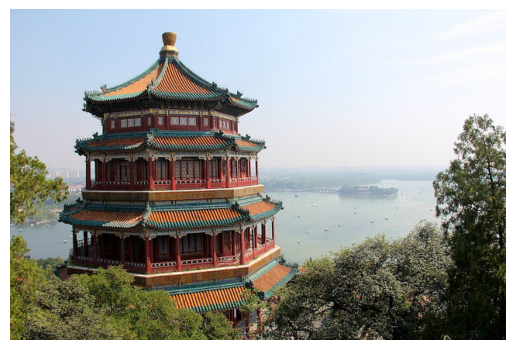

In [9]:
plt.imshow(images[0])
plt.axis('off')
plt.show()

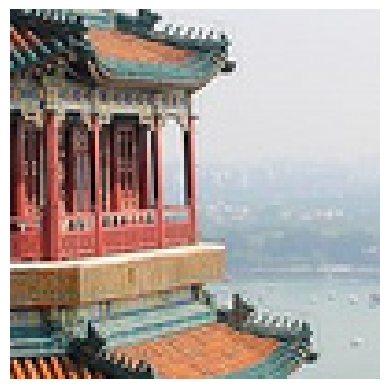

In [11]:
plt.imshow(cropped_images[0] / 255)
plt.axis('off')
plt.show()